In [329]:
%matplotlib inline

import numpy as np
import msprime
import pandas as pd
import scipy.stats as sc
import allel
#import toytree
import toyplot
import matplotlib.pyplot as plt
from IPython.display import SVG, display
def show_svg(f):
    display(SVG(filename=f))

sequence_length=500


In [2]:
def get_dxy(ihaps_t, mhaps_t):
    ## If no seg sites in a pop then haplotypes will be 0 length
    if ihaps_t.size == 0 or mhaps_t.size == 0:
        return 0

    ## Number of comparisons is == to n_island * n_metacommunity`
    ## n_metacommunity
    n_island = ihaps_t.shape[1]
    n_meta = mhaps_t.shape[1]
    n_comparisons = n_island * n_meta

    dxy = 0
    len_seq = ihaps_t.shape[0]

    ## ibases and mbases are now a list of all bases at a particular
    ## site within each population
    ## There's probably a more elegant way to do this but I was
    ## gunning for readibility. Probably failed.
    for ibases, mbases in zip(ihaps_t, mhaps_t):
        nonzeros_island = np.count_nonzero(ibases)
        nonzeros_meta = np.count_nonzero(mbases)
        zeros_island = n_island - nonzeros_island
        zeros_meta = n_meta - nonzeros_meta

        dxy += (nonzeros_island * zeros_meta \
                + zeros_island * nonzeros_meta) / float(n_comparisons)
    return dxy

00000000010
00001101001
11000100100
00001101001
01000100100
01110100000
00001111001
01000100100
00000000010
00001111001


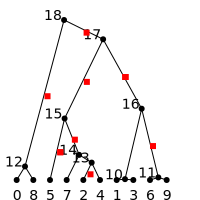

In [83]:
ts = msprime.simulate(sample_size=10, Ne=10000, mutation_rate=1e-7, length=1e3)
tree = next(ts.trees())
f = "/tmp/wat.svg"
tree.draw(f)
for x in ts.haplotypes():
    print(x)
show_svg(f)

In [36]:
tree_sequence = ms.simulate(sample_size=100, Ne=10000, length=1000, mutation_rate=1e-8 )
tree_sequence.get_pairwise_diversity()

0.7424242424242424

In [1017]:
def simseqs(sample_size=10, structured=False, TMRCA=220e3, T_Ext=21.2e1, Ne=100000, mig=3e-3, debug=False):

    T_MRCA = TMRCA
    T_Extinction = T_Ext
    m_a_u = mig
    m_b_u = mig

    ## Panmictic
    if not structured:
        m_a_u = 0.2
        m_b_u = 0.2
        Ne = 2*Ne

    sample_size=sample_size

    ancpopa = msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne)
    ancpop_unsampled = msprime.PopulationConfiguration(sample_size=0, initial_size=Ne)
    ancpopb = msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne)

    ## All lineages coalesce at some point in the past
    atou_event = msprime.MassMigration(time=T_MRCA, source=0, destination=1, proportion=1.0)
    btou_event = msprime.MassMigration(time=T_MRCA, source=2, destination=1, proportion=1.0)

    au_change = msprime.MigrationRateChange(time=T_Extinction, rate=m_a_u, matrix_index=(0,1))
    ua_change = msprime.MigrationRateChange(time=T_Extinction, rate=m_a_u, matrix_index=(1,0))
    bu_change = msprime.MigrationRateChange(time=T_Extinction, rate=m_b_u, matrix_index=(2,1))
    ub_change = msprime.MigrationRateChange(time=T_Extinction, rate=m_b_u, matrix_index=(1,2))

    if structured:
        
        demographic_events = [au_change, ua_change, bu_change, ub_change, atou_event, btou_event]
    else:
        ## All lineages coalesce at some point in the past
        panmictic_event0 = msprime.MassMigration(time=T_Extinction, source=0, destination=1, proportion=1.0)
        panmictic_event1 = msprime.MassMigration(time=T_Extinction, source=2, destination=1, proportion=1.0)
        demographic_events = [panmictic_event0, panmictic_event1]
        #demographic_events = [au_change, ua_change, bu_change, ub_change, atou_event, btou_event]

    dp = msprime.DemographyDebugger(
            Ne=Ne,
            population_configurations=[ancpopa, ancpop_unsampled, ancpopb],
            demographic_events=demographic_events)
    if debug:
        dp.print_history()

    ts = msprime.simulate(length=sequence_length,\
            Ne=Ne,\
            mutation_rate=1e-8, \
            population_configurations=[ancpopa, ancpop_unsampled, ancpopb],
            demographic_events=demographic_events)

    if debug:
        tree = next(ts.trees())
        f = "/tmp/wat.svg"
        tree.draw(f, height=600, width=600)
        show_svg(f)
    return ts.haplotypes()

In [826]:
#%%timeit
seqs = simseqs(sample_size=5, structured=False)
print([x for x in seqs])

['01010000000100001010011000100000001100000101011001100000000', '10100000001011000000000010011010100000000010100100000011010', '00100100110001100101100111010110010000111010100100001101100', '00100101010001100101100111010110010010111010100100001001100', '01010000000100000010011000100001001100000101011000110000000', '00100101010001100101100111010110010010111010100100001001100', '01011010000100000010011000100000001101000101011000100000001', '01010000000100010010011000100001001100000101011010110000000', '10100000001011000000000010011010100000000010100100000011010', '01010000000100001010011000100000001100000101011001100000000']


In [940]:
def do_sims(sample_size=10, structured=False, TMRCA=220e3, T_Ext=21.2e1, Ne=100000, mig=3e-3, debug=False):
    samps = sample_size
    haps = {x:[] for x in range(sample_size)}
    for i in range(sample_size):
        haps = simseqs(sample_size=samps, structured=structured, TMRCA=TMRCA, T_Ext=T_Ext, Ne=Ne, mig=mig, debug=debug)
        #print(len(list(haps)))
        ahaps = [next(haps) for _ in range(samps)]
        bhaps = [next(haps) for _ in range(samps)]
        ahaps_t = np.transpose(np.array([map(int, list(x)) for x in ahaps]))
        bhaps_t = np.transpose(np.array([map(int, list(x)) for x in bhaps]))
        if debug:
            print(len(ahaps), len(bhaps))
            #print(ahaps, bhaps)
            print(len(ahaps_t), len(bhaps_t))
            #print(ahaps_t, bhaps_t)

        anchapsa = []
        anchapsb = []
        nanchaps = 0
        for j in xrange(len(ahaps_t)):
            ## If ancestral polymorphism segregates in both samples then keep it
            try:
                ## This is slightly wrong, since it doesn't include the possibility 
                ## that a 1 has fixed in either of the populations
                #if len(set(ahaps_t[j])) > 1 and len(set(bhaps_t[j])) > 1:
                if 1 in ahaps_t[j] and 1 in bhaps_t[j]:
                    anchapsa.append(ahaps_t[j])
                    anchapsb.append(bhaps_t[j])
                    nanchaps += 1
            except Exception as inst:
                print(j)
                print(ahaps_t)
                print(bhaps_t)
        full = get_dxy(ahaps_t, bhaps_t)/sequence_length
        anc_only = get_dxy(np.array(anchapsa), np.array(anchapsb))/sequence_length
        #print(ahaps, bhaps, anchapsa, anchapsb)
        return full, anc_only, nanchaps


Epoch: 0 -- 100000.0 generations
     start     end      growth_rate |     0        1        2    
   -------- --------       -------- | -------- -------- -------- 
0 |  2e+05    2e+05               0 |     0        0        0    
1 |  2e+05    2e+05               0 |     0        0        0    
2 |  2e+05    2e+05               0 |     0        0        0    

Events @ generation 100000.0
   - Mass migration: lineages move from 0 to 1 with probability 1.0
   - Mass migration: lineages move from 2 to 1 with probability 1.0

Epoch: 100000.0 -- inf generations
     start     end      growth_rate |     0        1        2    
   -------- --------       -------- | -------- -------- -------- 
0 |  2e+05    2e+05               0 |     0        0        0    
1 |  2e+05    2e+05               0 |     0        0        0    
2 |  2e+05    2e+05               0 |     0        0        0    



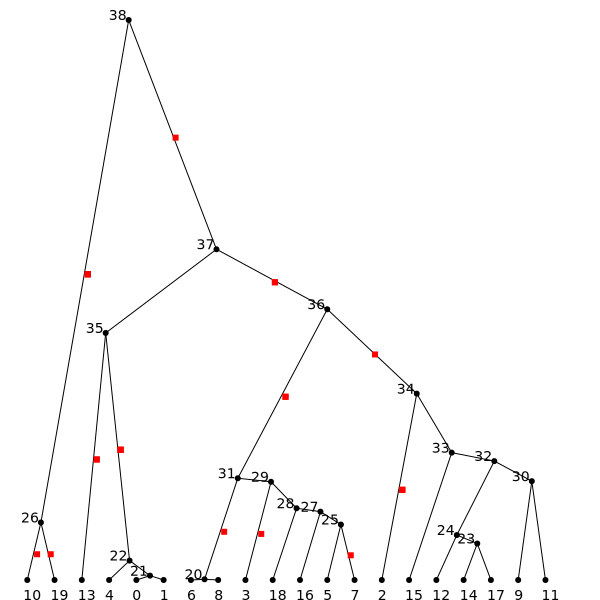

(10, 10)
(23, 23)


(0.010680000000000002, 0.00508, 6)

In [1123]:
##%%timeit
Ne=100000
do_sims(debug=True, sample_size=10, structured=False, Ne=Ne, T_Ext=1*Ne, TMRCA=5*Ne, mig=1./Ne)


## Data structure
So here we create 2 dictionaries of dictionaries. At the bottom level we're holding Dxy values for various extinction
times in the past. We're doing this for 2 conditions and 2 different amounts of data.

    full - This dictionary includes dxy values calculated from the full sequence
    anc_only - This dictionary only includes polymorphism that segragates in both populations still

For each of these cases there are 2 demographic scenarios involving 3 populations that are connected in a stepping stone fashion. In both cases only the 2 most distand populations are sampled (so the "bridge" population is unsampled, this is the population that is going "extinct").

    panmict - 2 populations from a fully panmictic model
    structured - The 3 populations experience symmetric gene flow, which should approximate clinal variation

In [1125]:
Ne=100000
## Rosenberg 2002
TMRCA = 5*Ne
mig = 0./Ne
samps = 40
TEXTS = [1, 0.25*Ne, 0.5*Ne, Ne, 2*Ne, 4*Ne]
full = {"panmict":{}, "structured":{}}
anc_only = {"panmict":{}, "structured":{}}

## Populate the dictionary for each ext time
for t in TEXTS:
    full["panmict"][t] = []
    full["structured"][t] = []
    anc_only["panmict"][t] = []
    anc_only["structured"][t] = []

nsims = 200
for t in TEXTS:
    print("\nDoing {}".format(t)),
    for x in range(nsims):
        print(". "),
        a, b, c = do_sims(sample_size=samps, structured=False, TMRCA=TMRCA, T_Ext=t, Ne=Ne, mig=mig)
        full["panmict"][t].append(a)
        anc_only["panmict"][t].append(b)

        a, b, c = do_sims(sample_size=samps, structured=True, TMRCA=TMRCA, T_Ext=t, Ne=Ne, mig=mig)
        full["structured"][t].append(a)
        anc_only["structured"][t].append(b)

print(full["panmict"][t][0])


Doing 1 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
Doing 25000.0 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .

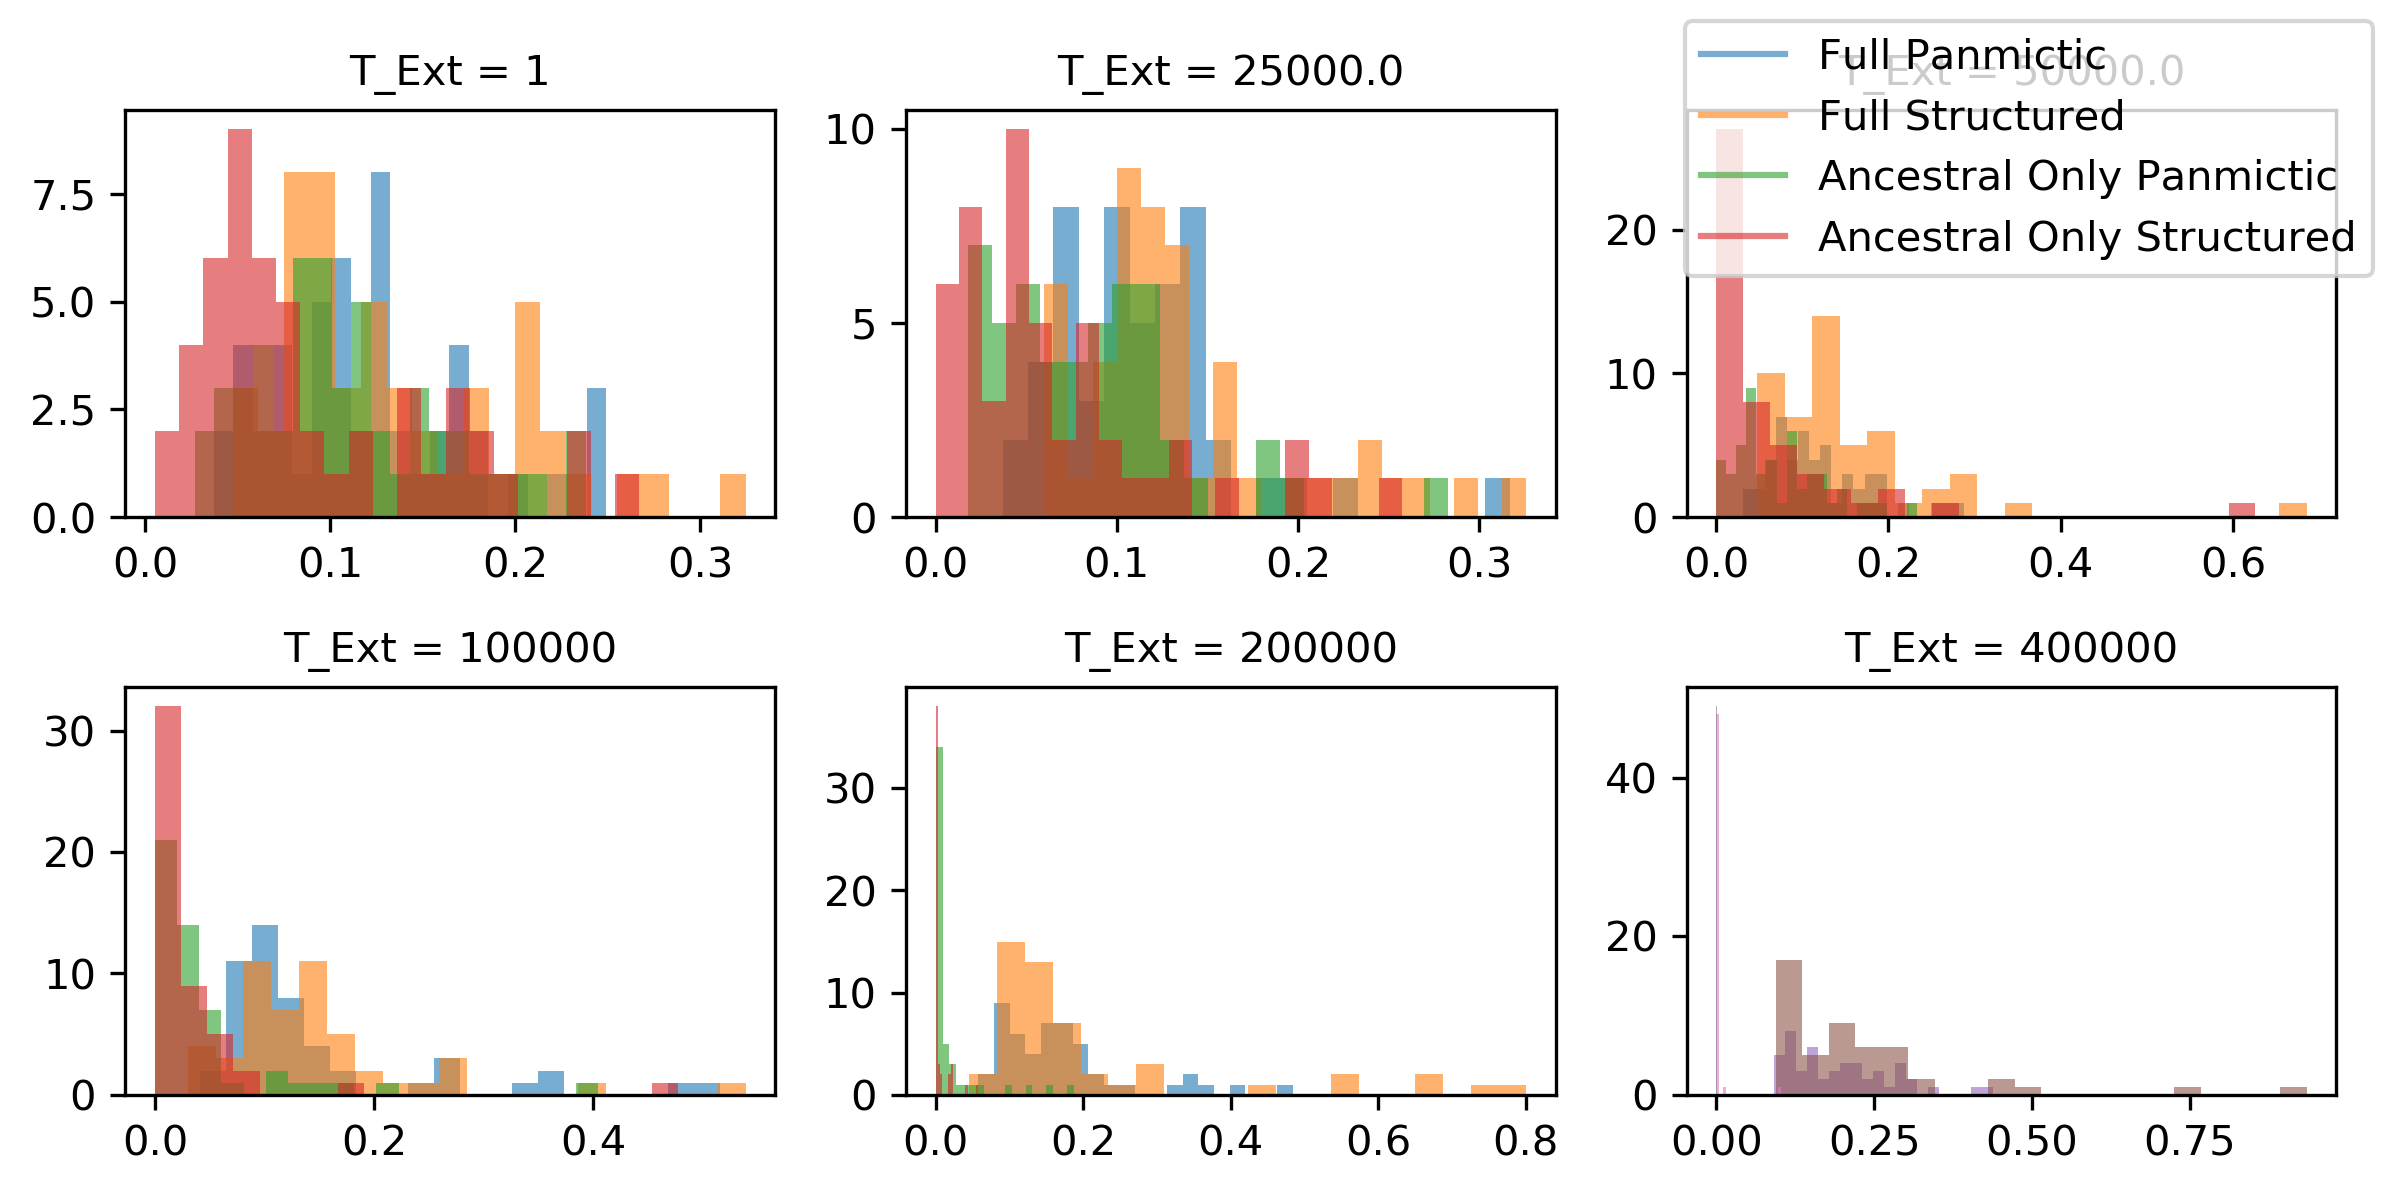

In [345]:
## Plot everything on one giant plot. It's impossible to see what's happening
f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300, sharex=False)
axarr = [a for b in axarr for a in b]

## Proxy lines for the legend
plt.plot([], label="Full Panmictic", alpha=0.6)  
plt.plot([], label="Full Structured", alpha=0.6)
plt.plot([], label="Ancestral Only Panmictic", alpha=0.6)  
plt.plot([], label="Ancestral Only Structured", alpha=0.6)


for i, t, ax in zip(xrange(0,6), TEXTS, axarr):
    _, _, _ = ax.hist(full["panmict"][t], alpha=0.6, bins=20)
    _, _, _ = ax.hist(full["structured"][t], alpha=0.6, bins=20)
    _, _, _ = ax.hist(anc_only["panmict"][t], alpha=0.6, bins=20)
    _, _, _ = ax.hist(anc_only["structured"][t], alpha=0.6, bins=20)
    ax.set_title("T_Ext = {}".format(t), fontsize=10)
_ = f.legend()
plt.tight_layout()

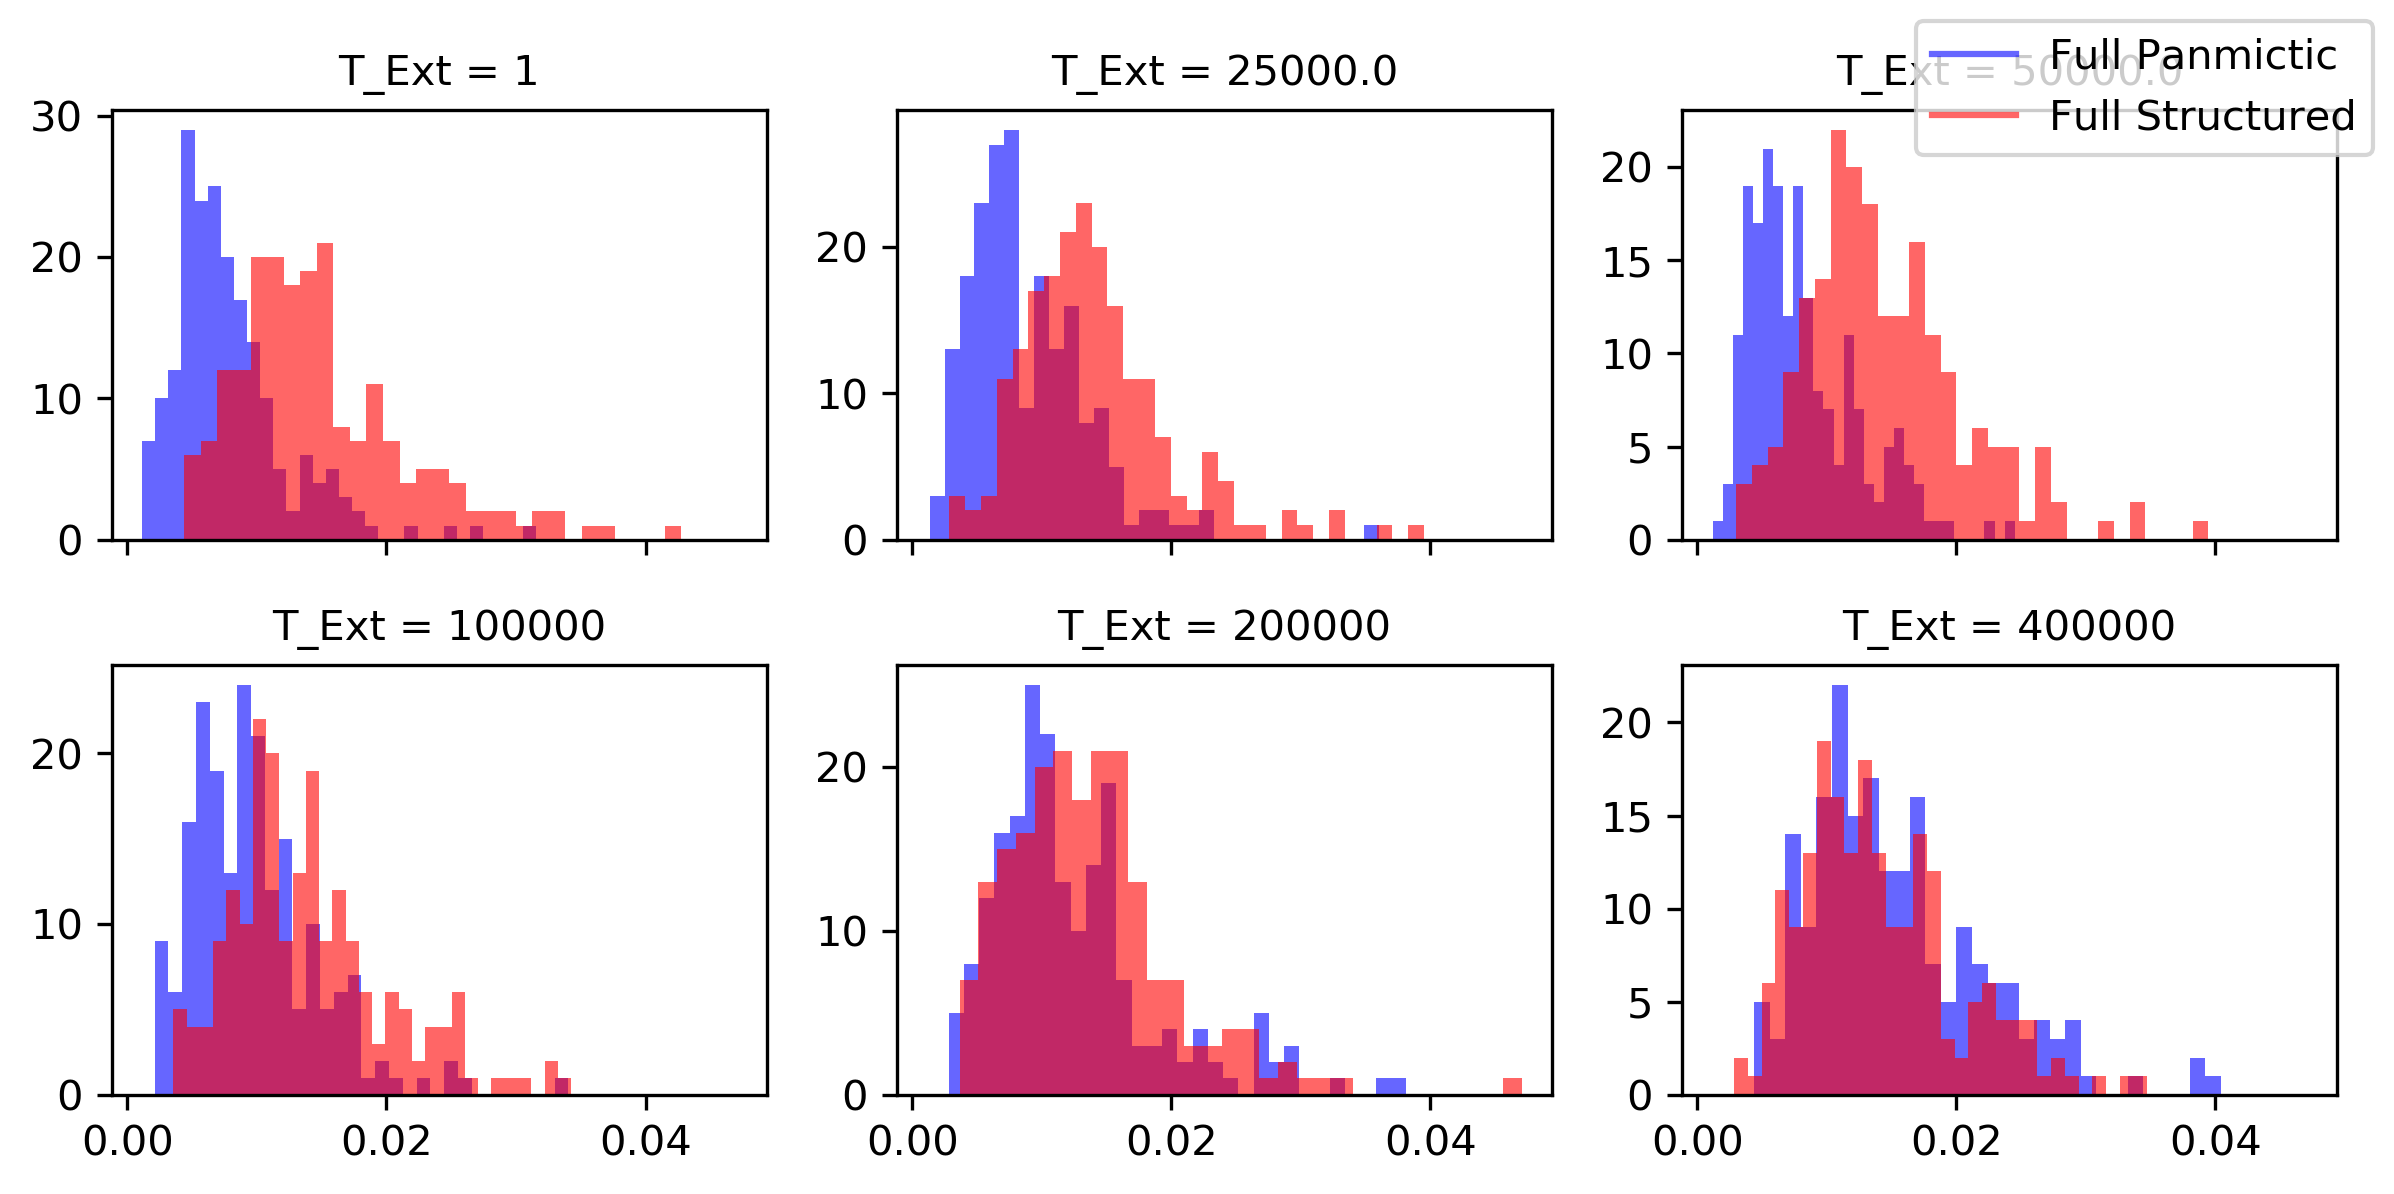

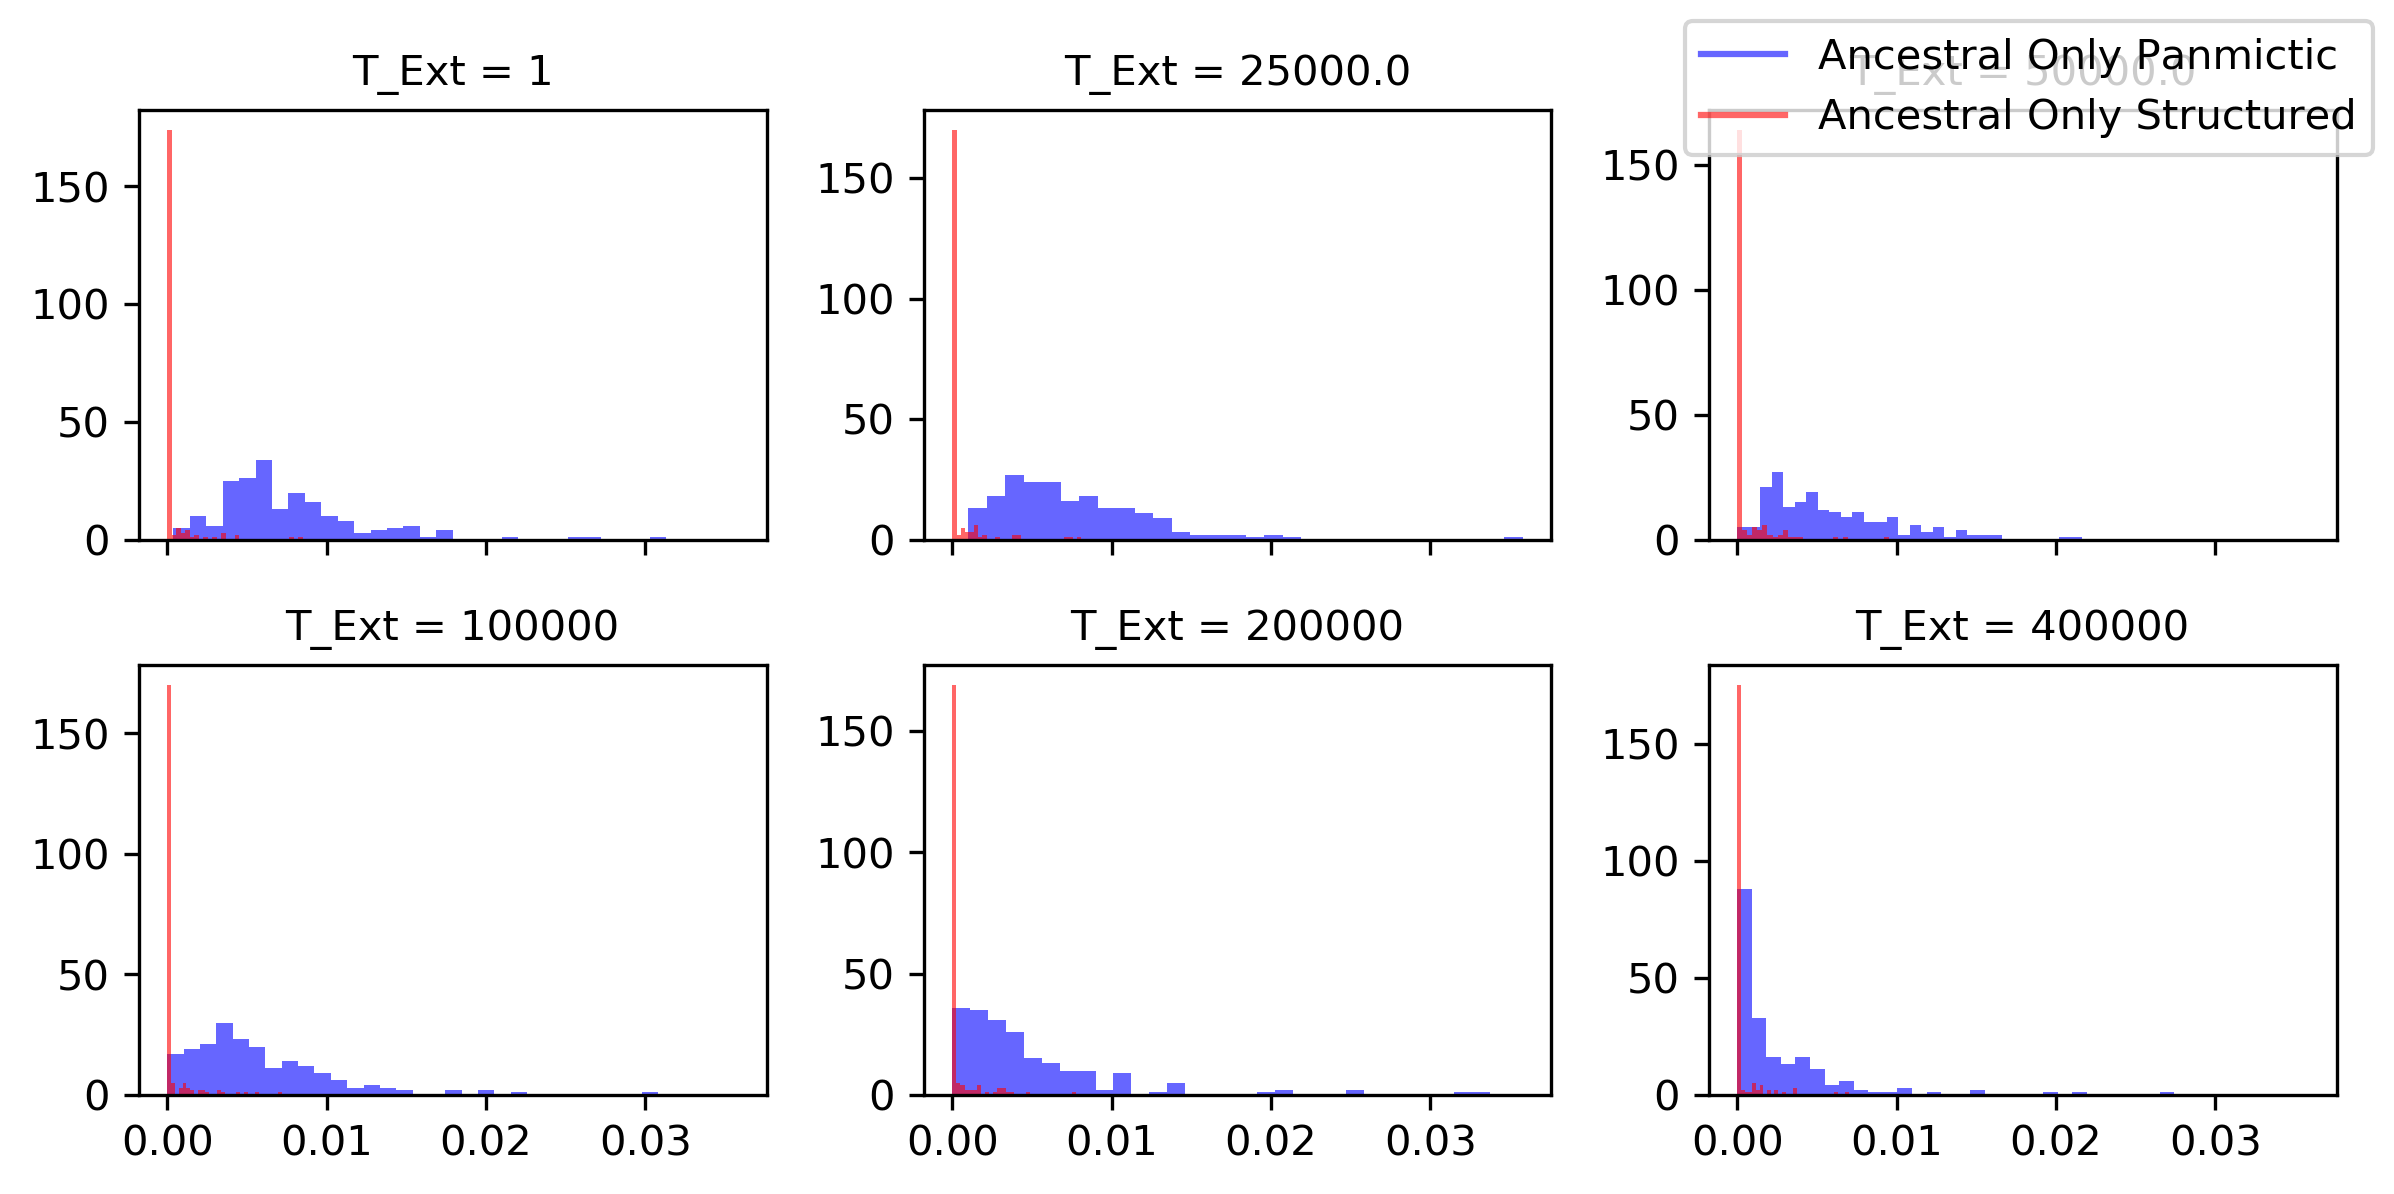

In [1126]:
f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300, sharex=True)
axarr = [a for b in axarr for a in b]

## Draw invisible proxy lines for the legend
plt.plot([], label="Full Panmictic", color="blue", alpha=0.6)  
plt.plot([], label="Full Structured", color="red", alpha=0.6)

for i, t, ax in zip(xrange(0,6), TEXTS, axarr):
    _, _, _ = ax.hist(full["panmict"][t], alpha=0.6, color="blue", bins=30)
    _, _, _ = ax.hist(full["structured"][t], alpha=0.6, color="red", bins=30)
    ax.set_title("T_Ext = {}".format(t), fontsize=10)
_ = f.legend()
plt.tight_layout()

f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300, sharex=True)
axarr = [a for b in axarr for a in b]

plt.plot([], label="Ancestral Only Panmictic", color="blue", alpha=0.6)  
plt.plot([], label="Ancestral Only Structured", color="red", alpha=0.6)

for i, t, ax in zip(xrange(0,6), TEXTS, axarr):
    _, _, _ = ax.hist(anc_only["panmict"][t], alpha=0.6, color="blue", bins=30)
    _, _, _ = ax.hist(anc_only["structured"][t], alpha=0.6, color="red", bins=30)
    ax.set_title("T_Ext = {}".format(t), fontsize=10)
_ = f.legend()
plt.tight_layout()


## Plot the ratio of full Dxy to anc_only

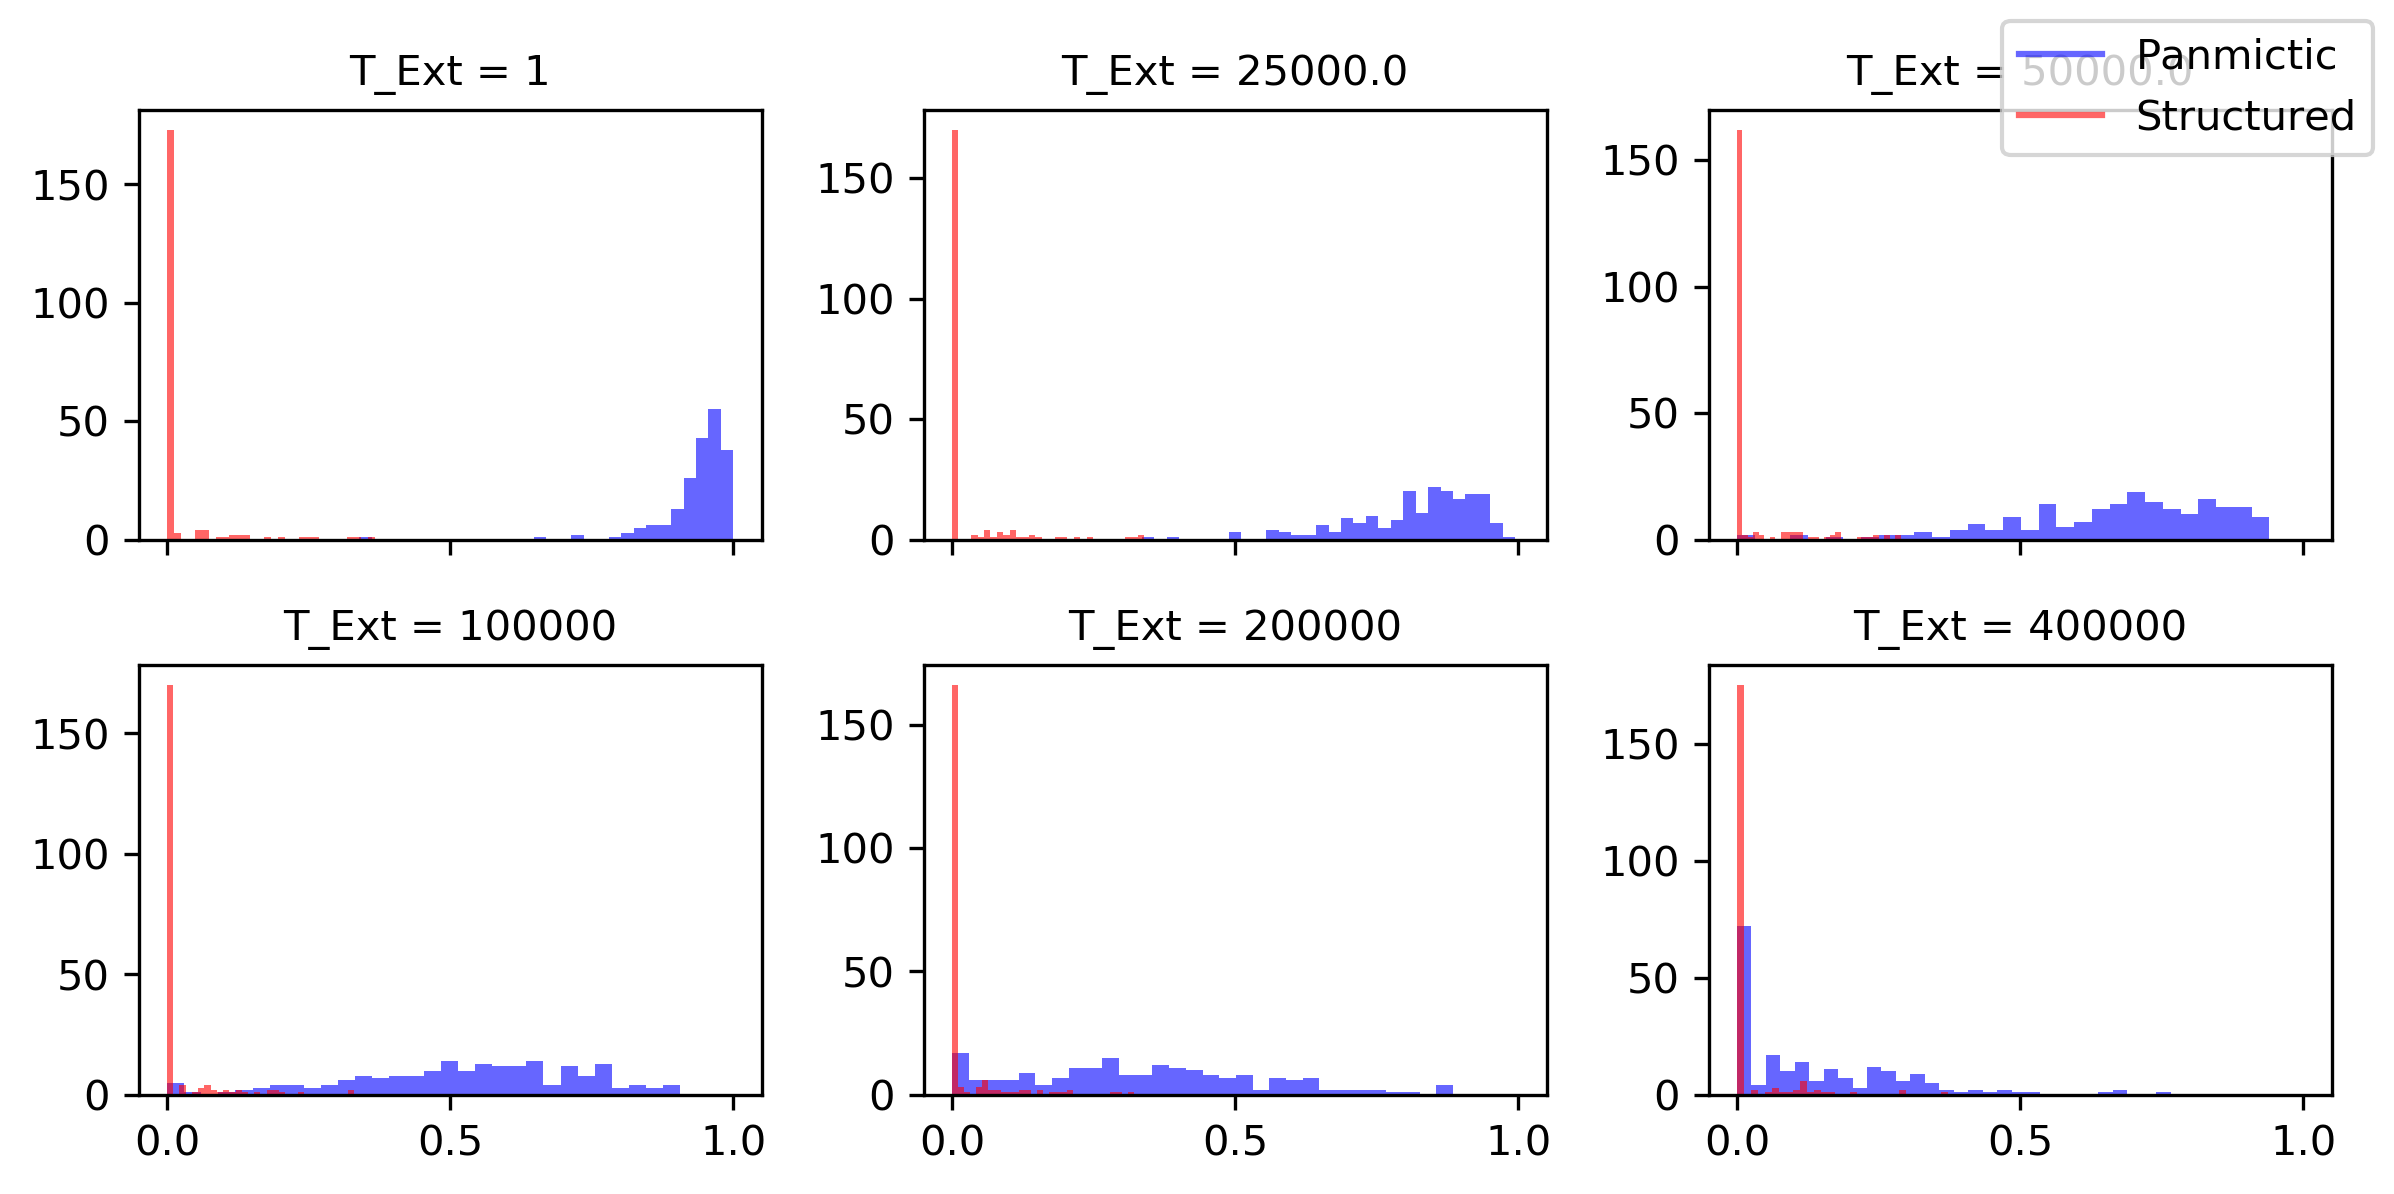

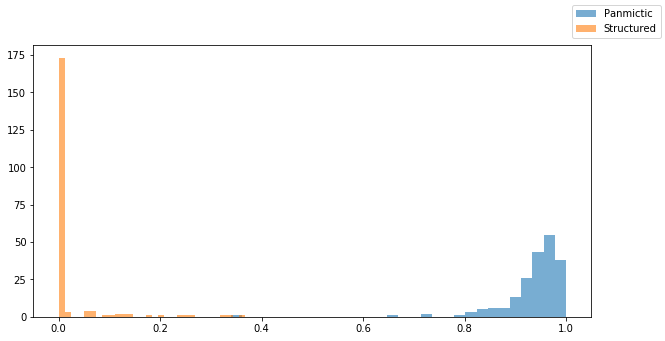

In [1127]:
f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300, sharex=True)
axarr = [a for b in axarr for a in b]

## Draw invisible proxy lines for the legend
plt.plot([], label="Panmictic", color="blue", alpha=0.6)  
plt.plot([], label="Structured", color="red", alpha=0.6)

for i, t, ax in zip(xrange(0,6), TEXTS, axarr):
    _, _, _ = ax.hist(np.array(anc_only["panmict"][t])/np.array(full["panmict"][t]), color="blue", alpha=0.6, bins=30)
    _, _, _ = ax.hist(np.array(anc_only["structured"][t])/np.array(full["structured"][t]), color="red", alpha=0.6, bins=30)
    ax.set_title("T_Ext = {}".format(t), fontsize=10)
_ = f.legend()
plt.tight_layout()

fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot(111)
_, _, _ = ax1.hist(np.array(anc_only["panmict"][1])/np.array(full["panmict"][1]), alpha=0.6, label="Panmictic", bins=30)
_, _, _ = ax1.hist(np.array(anc_only["structured"][1])/np.array(full["structured"][1]), alpha=0.6, label="Structured", bins=30)
_ = fig.legend()

## Just do one timepoint

In [1043]:
## Just do one timepoint
Ne=100000
## Rosenberg 2002
TMRCA = 5*Ne
mig = 1./Ne

t_ext = 1
full_one = {}
anc_only_one = {}
anc_allels_one = {}
for t in [t_ext]:
    full_one["panmict"] = []
    full_one["structured"] = []
    anc_only_one["panmict"] = []
    anc_only_one["structured"] = []
    anc_allels_one["panmict"] = []
    anc_allels_one["structured"] = []

nsims = 500
for t in [t_ext]:
    print("\nDoing {}".format(t)),
    for x in range(nsims):
        print("."),
        a, b, c = do_sims(sample_size=20, structured=False, TMRCA=TMRCA, T_Ext=t, Ne=Ne, mig=mig)
        full_one["panmict"].append(a)
        anc_only_one["panmict"].append(b)
        anc_allels_one["panmict"].append(c)

        a, b, c = do_sims(sample_size=20, structured=True, TMRCA=TMRCA, T_Ext=t, Ne=Ne, mig=mig)
        full_one["structured"].append(a)
        anc_only_one["structured"].append(b)
        anc_allels_one["structured"].append(c)

print(full_one["panmict"][0])


Doing 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

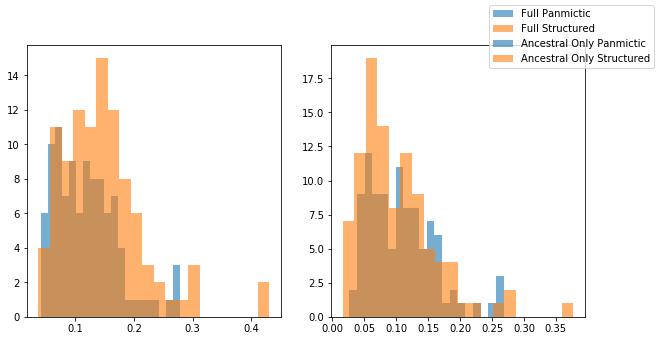

In [608]:
fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
_, _, _ = ax1.hist(full_one["panmict"], alpha=0.6, label="Full Panmictic", bins=20)
_, _, _ = ax1.hist(full_one["structured"], alpha=0.6, label="Full Structured", bins=20)
_, _, _ = ax2.hist(anc_only_one["panmict"], alpha=0.6, label="Ancestral Only Panmictic", bins=20)
_, _, _ = ax2.hist(anc_only_one["structured"], alpha=0.6, label="Ancestral Only Structured", bins=20)
_ = fig.legend()

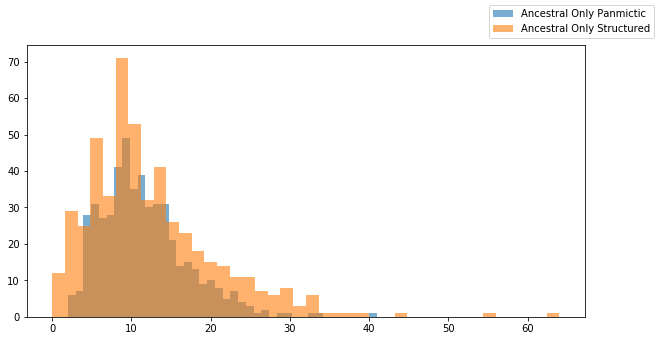

In [1045]:
## Number of shared ancestral polymorphisms
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)
_, _, _ = ax.hist(anc_allels_one["panmict"], alpha=0.6, label="Ancestral Only Panmictic", bins=40)
_, _, _ = ax.hist(anc_allels_one["structured"], alpha=0.6, label="Ancestral Only Structured", bins=40)
_ = fig.legend()

In [505]:
for k, v in anc_only_one.items():
    print(k, len(v))
    print(v[:20])

('panmict', 25)
[0.07630999999999996, 0.13959000000000002, 0.14114999999999975, 0.14575000000000005, 0.046099999999999995, 0.038730000000000014, 0.11166999999999992, 0.1378700000000001, 0.1014100000000001, 0.13194999999999996, 0.08363000000000007, 0.05923999999999998, 0.05470000000000002, 0.09476999999999984, 0.06999999999999992, 0.08443999999999996, 0.12902000000000002, 0.10159999999999997, 0.12478999999999986, 0.058400000000000014]
('structured', 25)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
